In [1]:
%load_ext autoreload
%autoreload 2

Fitting time series to CARMA models using __EzTao__ can be done in just one line. In this notebook, we demonstrate how to quickly get a reliable best-fit CARMA parameters using the built-in fitting functions. However, you are not bond to those built-in functions; you can use the CARMA kernels to compute likelihood and combine that with other optimizers to get the best-fit parameters, which we will also demonstrate in this notebook.

### 1. The built-in fitting functions

There are three built-in fitting functions:
- `drw_fit`: Fit input time series to a DRW model
- `dho_fit`: Fit input time series to a DHO/CARMA(2,1) model
- `carma_fit`: Fit input time series to an arbitrary CARMA model.

The first two should be used if you want to fit data to DRW or DHO, and the last one is a more general fitting function. Next, let's take a good at the `carma_fit` function.

In [2]:
from eztao.ts import carma_fit

In [3]:
carma_fit?

Signature:
carma_fit(
    t,
    y,
    yerr,
    p,
    q,
    de=True,
    debug=False,
    mode='coeff',
    user_bounds=None,
    n_iter=10,
)
Docstring:
Fit time series to any CARMA model.

Args:
    t (object): An array of time stamps in days.
    y (object): An array of y values.
    yerr (object): An array of the errors in y values.
    p (int): P order of a CARMA(p, q) model.
    q (int): Q order of a CARMA(p, q) model.
    de (bool, optional): Whether to use differential_evolution as the
        optimizer. Defaults to True.
    debug (bool, optional): Turn on/off debug mode. Defaults to False.
    mode (str, optional): Specify which space to sample, 'param' or 'coeff'.
        Defaults to 'coeff'.
    user_bounds (list, optional): Factorized polynomial coefficient boundaries
        for the optimizer. Defaults to None.
    n_iter (int, optional): Number of iterations to run the optimizer if de==False.
        Defaults to 10.

Raises:
    celerite.solver.LinAlgError: For non-p

Without going into the details, let's try to simulate a DHO process and fit the simulated time series using `carma_fit`.

In [4]:
import numpy as np
from eztao.carma import DHO_term
from eztao.ts import gpSimRand

# define kernel
dho_kernel = DHO_term(np.log(0.04), np.log(0.0027941), np.log(0.004672), 
                      np.log(0.0257))

# simulate a DHO process
nLC = 1
t, y, yerr = gpSimRand(dho_kernel, 10, 365*10, 200, nLC=nLC)

In [5]:
%%time
# fit
best_fit = carma_fit(t, y, yerr, 2, 1)

print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {best_fit}')
print('----------------------------------------------------')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.02492358 0.00271064 0.00432164 0.02255924]
----------------------------------------------------
CPU times: user 558 ms, sys: 5.21 ms, total: 563 ms
Wall time: 564 ms


From the cell above, we can see that it took < 1 second to obtain a best-fit that is quite close to the input. The robust performance is a result of a combination of many carefully chosen fitting components, most importantly the $\mathit{celerite}$ backend and a powerful global optimizer. However, we want to note that to better fit time series to models with orders higher than CARMA(2,1), more robust global optimizer might be needed. In the last section, we will show how to choose your own optimizer to obtain best-fit parameters. 

#### _A Note on Optimizers:_
The built-in fitting functions provide two optimizers from which you can choose to use: 
- `scipy.optimize.differential_evolution`
- `scipy.optimize.minimize`: A modified version. 

The modification (run more iterations with different initializations) done on the second optimizer is to mitigate the possibility of getting trapped in local optima. You can choose which to use by setting the `de` argument in each fitting function. 

### 2. Fit time series to models higher than CARMA(2,1)

More care must be taken when fitting time series to CARMA models higher than CARMA(2,1). The reason is that for CARMA models more complex than CARMA(2,1), the vanilla CARMA parameter space is no longer continuous; in other words, a random set of CARMA parameters may not produce a stable CARMA process, thus cannot return a valid likelihood during the fitting process. The solution to this problem is to sample from a space spanned by the coefficients of the AR/MA characteristic polynomials in the factored form. To learn more about this property of CARMA, please check out the papers linked in the [00_Introduction](./00_Introduction.ipynb) notebook.

With __EzTao__, you don't need to worry about the transformation between these two spaces. All you need to do is to tell the `carma_fit` function to fit in the polynomial coefficient space by setting `mode` to 'coeff'. We will illustrate how to do that below.

In [6]:
# simulate a CARMA(3,0) process
from eztao.carma import CARMA_term

carma_kernel = CARMA_term(np.log([3, 3.189, 0.05]), np.log([0.5]))
t2, y2, yerr2 = gpSimRand(carma_kernel, 30, 365*10, 200, nLC=nLC)

Text(0.5, 1.0, 'Simulated CARMA(3,0) processes')

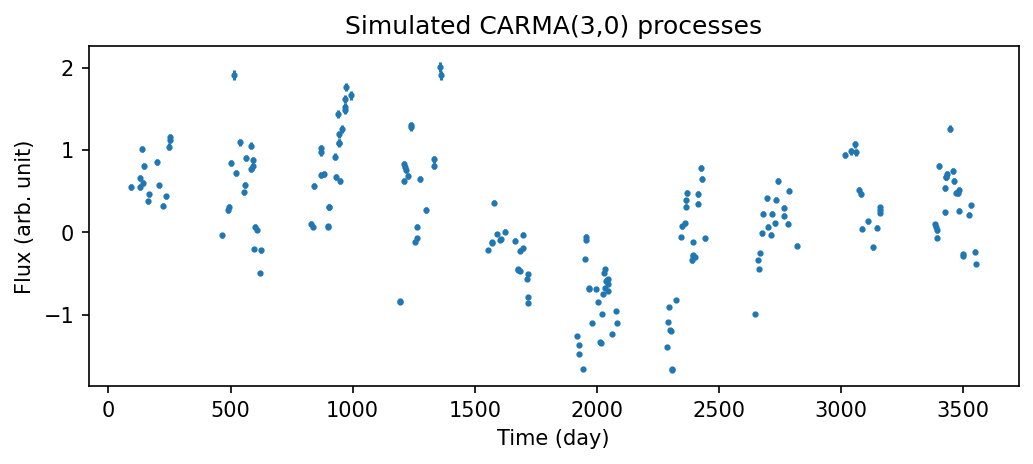

In [7]:
import matplotlib.pyplot as plt

# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t2, y2, yerr2, fmt='.', markersize=4)
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated CARMA(3,0) processes')

Now, let's fit the simulated process using CARMA(3,0)

In [8]:
%%time
# fit
best_fit2 = carma_fit(t2, y2, yerr2, 3, 0, de=False, mode='coeff')
print(f'True input CARMA(3,0) parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit CARMA(3,0) parameters: {best_fit2}')
print('----------------------------------------------------')

True input CARMA(3,0) parameters:[3.    3.189 0.05  0.5  ]
Best-fit CARMA(3,0) parameters: [1.14447301 1.09315076 0.01956948 0.15714748]
----------------------------------------------------
CPU times: user 554 ms, sys: 6.68 ms, total: 560 ms
Wall time: 562 ms


#### __Note:__ 
We stress that getting accurate best-fit parameters (without running long MCMC) for CARMA processes that are higher than CARMA(2,1) requires more robust optimizers than what's currently implemented. On the other hand, our experience taught us that the higher the order of the CARMA model that we are fitting the better the S/N that we will need in order obtain accurate and reliable best-fit.

### 3. Use your own optimizer
Using your own optimizer is very straight forward. All you need to do is using your optimizer to generate parameter proposals and use the CARMA kernels from __EzTao__ to compose a likelihood function. Caution should be taken when fitting to models that are higher than CARMA(2,1) as I explained above, and I will reemphasize below as well. I will use the steps shown in [$\mathit{celerite}$'s tutorials](https://celerite.readthedocs.io/en/stable/tutorials/first/) to illustrate the process. 

#### 3.1 Fit models that are equal or lower than CARMA(2,1)
The process to fit time series to those three models is no different than what's shown in $\mathit{celerite}$'s tutorials. You can compose your own likelihood function (`neg_log_like`) like what's demonstrated, __EzTao__ also provides the likelihood function: `neg_param_ll`, the equivalence of `neg_log_like`.

In [9]:
from celerite import GP
from eztao.ts import neg_param_ll
from eztao.ts import dho_log_param_init # only used to initialize kernel
from scipy.optimize import minimize

In [10]:
dho_kernel_fit = DHO_term(*dho_log_param_init())
gp = GP(dho_kernel_fit, mean=np.mean(y))
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -25101.114616129606


In [11]:
gp.kernel.set_parameter_vector(dho_log_param_init())
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_param_ll, initial_params, bounds=bounds, method="L-BFGS-B", args=(y, gp))
gp.set_parameter_vector(r.x)

In [12]:
print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(r.x)}')
print(f'Final likelihood: {gp.log_likelihood(y)}')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.02440775 0.0027334  0.00428213 0.02260997]
Final likelihood: 146.17015933464464


#### 3.2 Fit models that are higher than CARMA(2,1)
Fit time series to higher order models is not hard either, all you need to do is change `neg_param_ll` with `neg_fcoeff_ll`. If you would like to compose your own likelihood function, you need to change `gp.set_parameter_vector(params)` to `gp.kernel.set_log_fcoeffs(params)`. The current implementation doesn't allow combining CARMA kernels with other kernels (e.g., jitter or a trend), but future versions, especially after switching the backend to $\mathit{celerite2}$, we will look at adding this feature.

In [13]:
from eztao.ts.carma import sample_carma
from eztao.ts import neg_fcoeff_ll
from eztao.ts.carma import carma_log_fcoeff_init, carma_log_param_init

In [14]:
# randomly initializing a carma kernel (without verifying the validity)
rand_params = carma_log_param_init(4)
carma_kernel_fit = CARMA_term(np.array(rand_params[:3]), np.array(rand_params[3:]))

In [15]:
# initialize GP and update with valid parameters
init_coeff = carma_log_fcoeff_init(4)
gp2 = GP(carma_kernel_fit, mean=np.mean(y2))
gp2.kernel.set_log_fcoeffs(init_coeff)
gp2.compute(t2, yerr2)
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y2)))

Initial log likelihood: -4663.089890986434


In [16]:
initial_params = init_coeff

# giving a 'valid' boundary is often a good practice
# try it without the boundary yourself
ARbounds = [(-6, 1)] * 3
MAbounds = [(-6, -1)] * (0 + 1)
bounds = ARbounds + MAbounds

r2 = minimize(neg_fcoeff_ll, initial_params, bounds=bounds, method="L-BFGS-B", args=(y2, gp2))
gp2.kernel.set_log_fcoeffs(r2.x)

In [17]:
print(f'True input DHO parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(gp2.get_parameter_vector())}')
print(f'Final likelihood: {gp2.log_likelihood(y2)}')

True input DHO parameters:[3.    3.189 0.05  0.5  ]
Best-fit DHO parameters: [1.14230678 1.09206815 0.01960862 0.15690063]
Final likelihood: -32.89851150463414


---
### _Some Notes on Fitting_
- We can only do as good as the likelihood landscape allows (unless you can come up with a useful prior landscape)
- The likelihood landscape is highly influenced by the intrinsic quality of the input time series, such as sampling and the level of measurement noise.